XGBoost for oversampling

In [1]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from xgboost import XGBClassifier
# from adjustText import adjust_text


#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv("cell2cell_preprocess.csv")
data

Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0          0           83.50          1130.0                  75.0   
1          0           35.30           307.0                  35.0   
2          0           32.02           362.0                  32.0   
3          0          111.39           767.0                  75.0   
4          1           38.17           214.0                  30.0   
...      ...             ...             ...                   ...   
39567      0           71.99           724.0                  70.0   
39568      1          117.49           384.0                  30.0   
39569      1           48.46           366.0                  45.0   
39570      0           95.17          1745.0                  85.0   
39571      0           48.46           366.0                  45.0   

       DirectorAssistedCalls  RoamingCalls  PercChangeMinutes  \
0                       0.00           0.3               90.0   
1                       0.00           0.0              204.0   
2                       0.25           0.0               38.0   
3                       7.42           0.0             -243.0   
4                       0.00           0.0              202.0   
...                      ...           ...                ...   
39567                   0.00           0.9              -40.0   
39568                   0.00           0.0                0.0   
39569                   0.25           0.0               -5.0   
39570                   0.99           4.7              122.0   
39571                   0.25           0.0               -5.0   

       PercChangeRevenues  DroppedCalls  UnansweredCalls  ...  \
0                    10.0           3.0             18.0  ...   
1                    -0.3           1.0             24.3  ...   
2                    -1.2           2.3             18.7  ...   
3                     2.7           8.0             23.3  ...   
4                    14.6           1.3             18.3  ...   
...                   ...           ...              ...  ...   
39567                -2.0          14.3             23.3  ...   
39568                 0.0           4.0             27.0  ...   
39569                -0.3           9.3             48.3  ...   
39570                15.9          16.7             41.3  ...   
39571                -0.3           0.0              0.0  ...   

       RespondsToMailOffers  RetentionCalls  RetentionOffersAccepted  \
0                         0               0                        0   
1                         0               0                        0   
2                         1               0                        0   
3                         0               1                        1   
4                         1               0                        0   
...                     ...             ...                      ...   
39567                     1               0                        0   
39568                     0               0                        0   
39569                     1               0                        0   
39570                     1               0                        0   
39571                     0               0                        0   

       IncomeGroup  HandsetPrice  MadeCallToRetentionTeam  CreditRating  \
0                0          10.0                        0             0   
1                6          30.0                        0             0   
2                9          30.0                        0             0   
3                5          10.0                        1             0   
4                1          10.0                        0             2   
...            ...           ...                      ...           ...   
39567            7          60.0                        0             0   
39568            2          30.0                        0             4   
39569            6          60.0                        0       

In [3]:
X = data.drop(columns="Churn")
y = data["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("----------------------------")
print("Original features shape, ", X.shape)
print("Original target shape, ", y.shape)
print("x train shape, ", X_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", X_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (39572, 34)
Original target shape,  (39572,)
x train shape,  (31657, 34)
y train shape,  (31657,)
x test shape,  (7915, 34)
y test shape,  (7915,)
----------------------------


In [4]:
smote = SMOTE(random_state=42)
X_train_upsampled , y_train_upsampled = smote.fit_resample(X_train,y_train)
print("----------------------------")
print("Original x train shape, ", X_train.shape)
print("Resample x train shape, ", X_train_upsampled.shape)
print("----------------------------")

----------------------------
Original x train shape,  (31657, 34)
Resample x train shape,  (44732, 34)
----------------------------


In [5]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/cell2cell/oversampling.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
os_xgboost_params = next(model['hyperparameters'] for model in models if model['name'] == 'XGBoost')
os_xgboost_threshold = 0.563646
# Print the hyperparameters for each model
print("XGBoost Parameters:", os_xgboost_params)
print(f"XGBoost Threshold: {os_xgboost_threshold} ")

# Build model and evaluate
xai_model = XGBClassifier(**os_xgboost_params)
trained_xai_model = xai_model.fit(X_train_upsampled, y_train_upsampled)

XGBoost Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0.01, 'reg_lambda': 1}
XGBoost Threshold: 0.563646 


In [6]:
import shap
shap.initjs()

In [7]:
# For correct set
explainer = shap.TreeExplainer(model=trained_xai_model,data=X_train_upsampled,model_output="probability")

In [8]:
# explainer_ndarray = explainer.shap_values(X_test)
# explainer_object = explainer(X_test)

In [9]:
# import pickle

# # Save the explainer object using pickle
# with open("../../model_artifact/training/cell2cell/cell2cell_explainer.pkl", "wb") as f:
#     pickle.dump(explainer_object, f)


In [10]:
import pickle
# Load the explainer object using pickle
with open("../../model_artifact/training/cell2cell/cell2cell_explainer.pkl", "rb") as f:
    explainer_object = pickle.load(f)

In [11]:
# Cach cai cua XGBoost khac voi random forest nen la base value chi co v thoi
explainer_object

.values =
array([[-3.37808491e-03,  4.94282154e-02, -3.81458022e-02, ...,
        -6.85864833e-05, -1.11949279e-02,  5.95432268e-04],
       [ 3.19870192e-02, -4.31709563e-02,  5.46772548e-03, ...,
         2.36157927e-04, -6.49298370e-03,  6.66263735e-04],
       [-2.13685376e-02, -9.68732120e-03, -4.66590656e-02, ...,
         1.78593201e-03,  2.99993558e-03,  4.40372532e-04],
       ...,
       [-3.44307687e-02, -1.58724398e-03, -1.71277482e-02, ...,
         5.17621490e-05,  2.99998330e-02,  5.34568786e-04],
       [ 3.13255416e-03, -1.39806147e-02, -4.22255706e-02, ...,
        -3.05142042e-04, -8.15864916e-03,  2.15291135e-04],
       [-1.78303616e-02,  1.99068439e-02, -5.37469500e-02, ...,
        -1.66160647e-04, -4.45445641e-03,  2.25836517e-04]])

.base_values =
array([0.4894612, 0.4894612, 0.4894612, ..., 0.4894612, 0.4894612,
       0.4894612])

.data =
array([[ 17.93,  32.  ,  17.  , ...,   0.  ,   1.  ,   0.  ],
       [ 62.85, 524.  ,  50.  , ...,   0.  ,   1.  ,   0.  ]

# Local Interpret

In [12]:
X_test

MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
5557            17.93            32.0                  17.0   
6361            62.85           524.0                  50.0   
24854           49.84           354.0                  60.0   
11873           30.37           122.0                  30.0   
4217           121.03           773.0                  60.0   
...               ...             ...                   ...   
6813            62.72           754.0                  60.0   
15220           31.70            50.0                  10.0   
26168           30.09           209.0                  40.0   
27736           40.47           314.0                  22.0   
36130           35.75           136.0                  45.0   

       DirectorAssistedCalls  RoamingCalls  PercChangeMinutes  \
5557                    0.00           0.0               36.0   
6361                    0.25           0.0              159.0   
24854                   0.00           0.0               64.0   
11873                   0.00           0.1              -32.0   
4217                    0.25           2.4              131.0   
...                      ...           ...                ...   
6813                    2.23           0.0              524.0   
15220                   0.25           0.0              -36.0   
26168                   0.00           0.0              -24.0   
27736                   0.25           2.4             -286.0   
36130                   0.00           0.7               60.0   

       PercChangeRevenues  DroppedCalls  UnansweredCalls  CustomerCareCalls  \
5557                  2.2           0.7              1.7                0.0   
6361                  6.3           4.7              5.0                0.0   
24854                 8.6           4.3              8.3                1.3   
11873                -0.4           2.0              9.0                0.0   
4217                 37.3           8.7             20.3                0.0   
...                   ...           ...              ...                ...   
6813                 29.0          11.0             31.7                5.3   
15220               -18.0           1.0             20.3                0.0   
26168                -0.1           0.0             14.7                0.0   
27736               -28.7           0.7             21.3                4.3   
36130                 1.9           0.7              8.0                0.0   

       ...  RespondsToMailOffers  RetentionCalls  RetentionOffersAccepted  \
5557   ...                     1               0                        0   
6361   ...                     1               0                        0   
24854  ...                     0               0                        0   
11873  ...                     0               0                        0   
4217   ...                     0               0                        0   
...    ...                   ...             ...                      ...   
6813   ...                     0               1                        1   
15220  ...                     0               0                        0   
26168  ...                     1               0                        0   
27736  ...                     0               0                        0   
36130  ...                     0               0                        0   

       IncomeGroup  HandsetPrice  MadeCallToRetentionTeam  CreditRating  \
5557             4          60.0                        0             4   
6361             2          30.0                        0             2   
24854            0          60.0                        0             1   
11873            6          60.0                        0             1   
4217             0          80.0                        0             0   
...            ...           ...                      ...           ...   
6813             5         150.0                        1             

Label for instance 187: 0


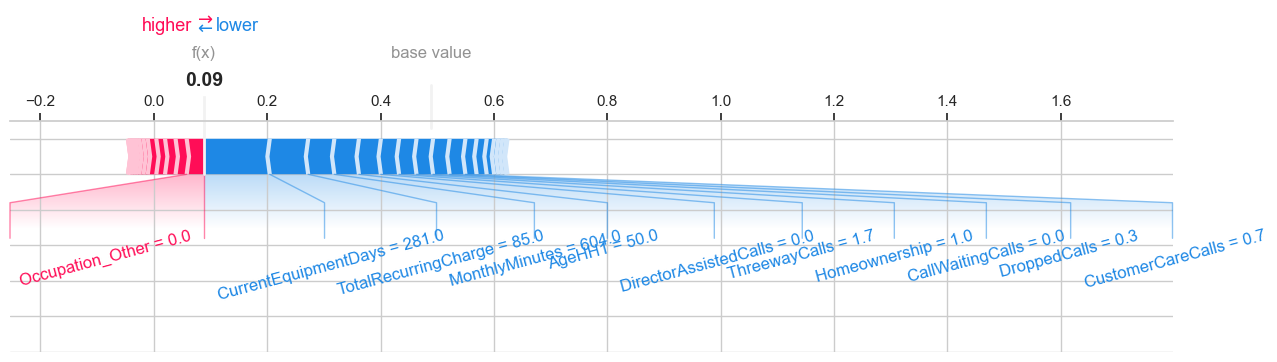

Label for instance 544: 0


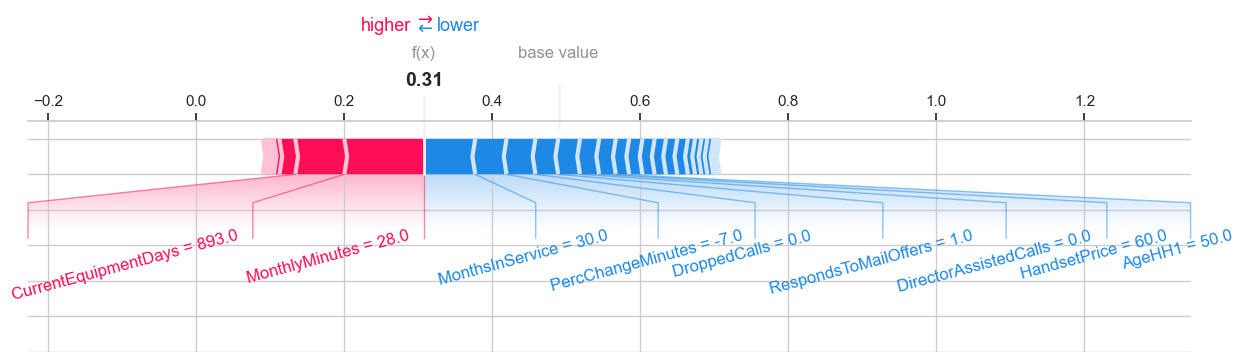

Label for instance 222: 1


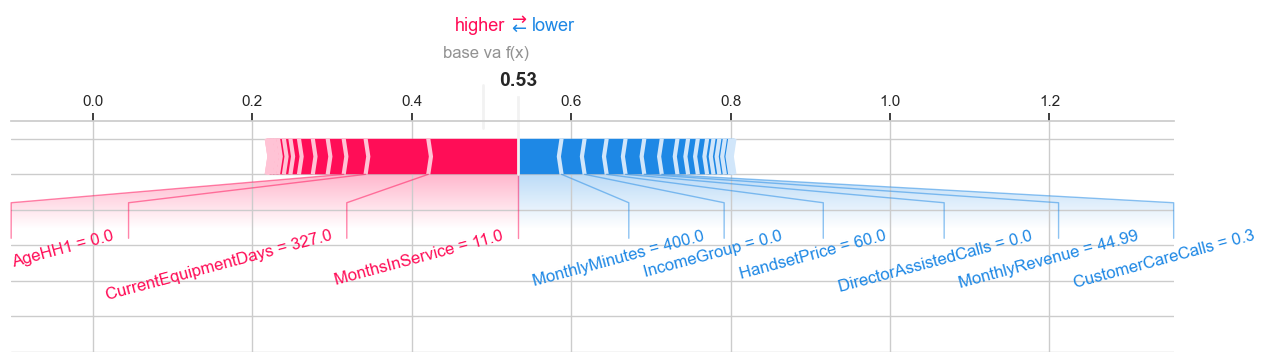

Label for instance 421: 0


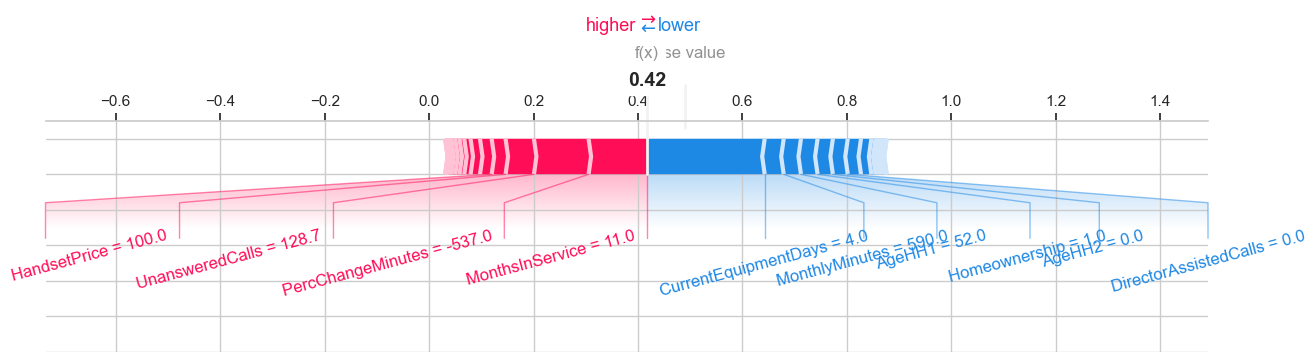

Label for instance 7000: 0


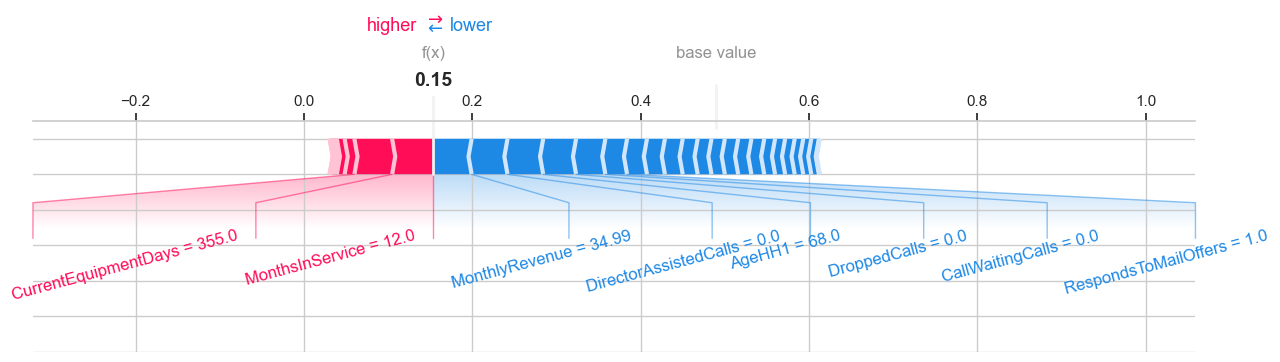

In [24]:
idx = [187, 544, 222, 421, 7000]
for i in [187, 544, 222, 421, 7000]:
    # Randomly sample an index from X_test

    # Get the corresponding instance and label
    instance = X_test.iloc[i:i+1]  # Single instance
    label = y_test.iloc[i]  # Corresponding label
    
    # Print out the label
    print(f"Label for instance {i}: {label}")
    
    # Generate SHAP values for the instance
    #shap_values = explainer(instance)
    
    # Plot the SHAP force plot for the sampled instance
    shap.force_plot(explainer_object.base_values[0], explainer_object.values[i,:], instance, matplotlib=True,text_rotation=15, figsize=(15,3))
    
    # Show the plot
    plt.show()

In [25]:
indices_list=[187, 544, 222, 421, 7000]
# Get the corresponding instances from X_test
instances = X_test.iloc[indices_list]

# Get the predicted probabilities for these instances
predicted_probabilities = trained_xai_model.predict_proba(instances)

# Print out the predicted probabilities for each instance
for idx, prob in zip(indices_list, predicted_probabilities):
    print(f"Instance {idx} - Predicted probability for class 1: {prob[1]}")
    
    # Check if the probability is approximately 0.4459
    if abs(prob[1] - os_xgboost_threshold) < 0.01:  # A small tolerance to check closeness
        print(f"Instance {idx} has a predicted probability close to 0.4459")


Instance 187 - Predicted probability for class 1: 0.08907371759414673
Instance 544 - Predicted probability for class 1: 0.30763301253318787
Instance 222 - Predicted probability for class 1: 0.5335325598716736
Instance 421 - Predicted probability for class 1: 0.41754764318466187
Instance 7000 - Predicted probability for class 1: 0.15376882255077362


In [15]:
X_test

MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
5557            17.93            32.0                  17.0   
6361            62.85           524.0                  50.0   
24854           49.84           354.0                  60.0   
11873           30.37           122.0                  30.0   
4217           121.03           773.0                  60.0   
...               ...             ...                   ...   
6813            62.72           754.0                  60.0   
15220           31.70            50.0                  10.0   
26168           30.09           209.0                  40.0   
27736           40.47           314.0                  22.0   
36130           35.75           136.0                  45.0   

       DirectorAssistedCalls  RoamingCalls  PercChangeMinutes  \
5557                    0.00           0.0               36.0   
6361                    0.25           0.0              159.0   
24854                   0.00           0.0               64.0   
11873                   0.00           0.1              -32.0   
4217                    0.25           2.4              131.0   
...                      ...           ...                ...   
6813                    2.23           0.0              524.0   
15220                   0.25           0.0              -36.0   
26168                   0.00           0.0              -24.0   
27736                   0.25           2.4             -286.0   
36130                   0.00           0.7               60.0   

       PercChangeRevenues  DroppedCalls  UnansweredCalls  CustomerCareCalls  \
5557                  2.2           0.7              1.7                0.0   
6361                  6.3           4.7              5.0                0.0   
24854                 8.6           4.3              8.3                1.3   
11873                -0.4           2.0              9.0                0.0   
4217                 37.3           8.7             20.3                0.0   
...                   ...           ...              ...                ...   
6813                 29.0          11.0             31.7                5.3   
15220               -18.0           1.0             20.3                0.0   
26168                -0.1           0.0             14.7                0.0   
27736               -28.7           0.7             21.3                4.3   
36130                 1.9           0.7              8.0                0.0   

       ...  RespondsToMailOffers  RetentionCalls  RetentionOffersAccepted  \
5557   ...                     1               0                        0   
6361   ...                     1               0                        0   
24854  ...                     0               0                        0   
11873  ...                     0               0                        0   
4217   ...                     0               0                        0   
...    ...                   ...             ...                      ...   
6813   ...                     0               1                        1   
15220  ...                     0               0                        0   
26168  ...                     1               0                        0   
27736  ...                     0               0                        0   
36130  ...                     0               0                        0   

       IncomeGroup  HandsetPrice  MadeCallToRetentionTeam  CreditRating  \
5557             4          60.0                        0             4   
6361             2          30.0                        0             2   
24854            0          60.0                        0             1   
11873            6          60.0                        0             1   
4217             0          80.0                        0             0   
...            ...           ...                      ...           ...   
6813             5         150.0                        1             

In [26]:
explainer_object.base_values

array([0.4894612, 0.4894612, 0.4894612, ..., 0.4894612, 0.4894612,
       0.4894612])

In [16]:
sample_size = 1500
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
shap.force_plot(base_value=explainer_object.base_values[0], 
                shap_values=explainer_object.values[sample_idx,:],
                features=X_test.iloc[sample_idx,:])

# Global Interpret

<Axes: >

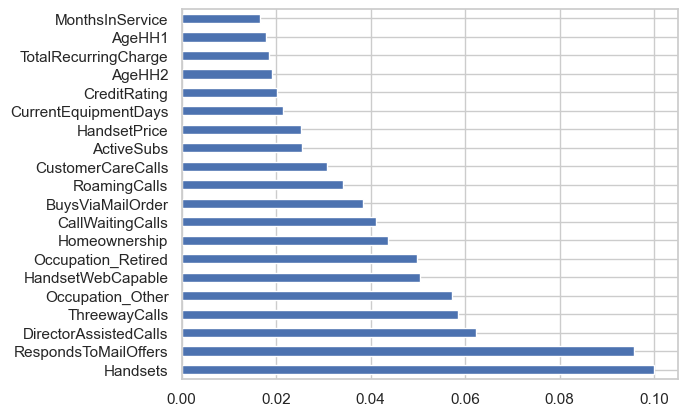

In [33]:
feat_importances = pd.Series(trained_xai_model.feature_importances_, index=X_train_upsampled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [31]:
X_test["CurrentEquipmentDays"]

5557     733.0
6361     321.0
24854    361.0
11873    571.0
4217     187.0
         ...  
6813     379.0
15220    503.0
26168    188.0
27736    124.0
36130    249.0
Name: CurrentEquipmentDays, Length: 7915, dtype: float64

In [17]:
feature_names = X_test.columns.to_list()
feature_names

['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'DroppedCalls',
 'UnansweredCalls',
 'CustomerCareCalls',
 'ThreewayCalls',
 'OutboundCalls',
 'InboundCalls',
 'CallWaitingCalls',
 'MonthsInService',
 'ActiveSubs',
 'Handsets',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'RetentionCalls',
 'RetentionOffersAccepted',
 'IncomeGroup',
 'HandsetPrice',
 'MadeCallToRetentionTeam',
 'CreditRating',
 'PrizmCode_Rural',
 'Occupation_Other',
 'Occupation_Retired']

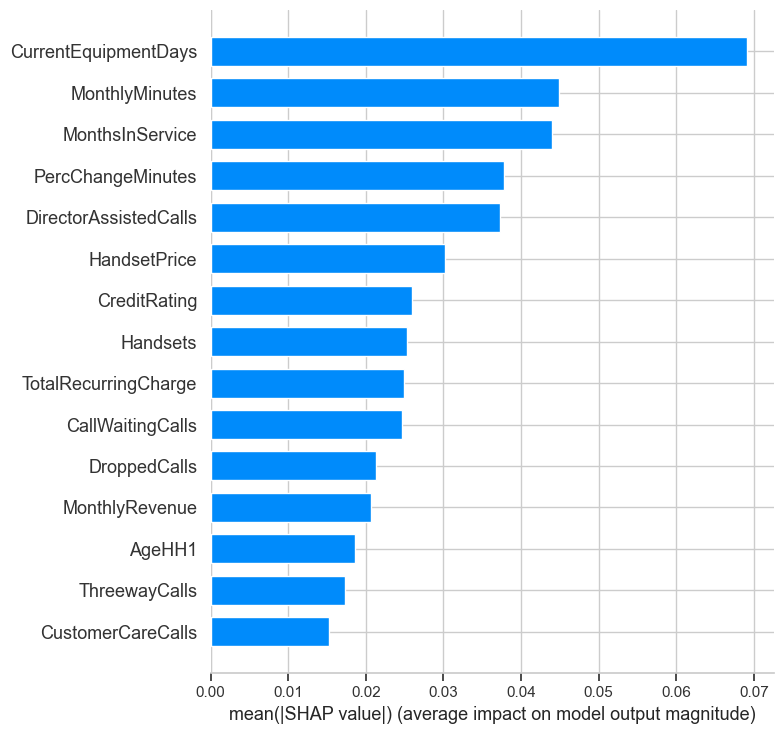

In [30]:
shap.summary_plot(shap_values=explainer_object.values[:,:],
                  features = X_test,
                  feature_names = feature_names,
                  max_display = 15,
                  plot_type = "bar")

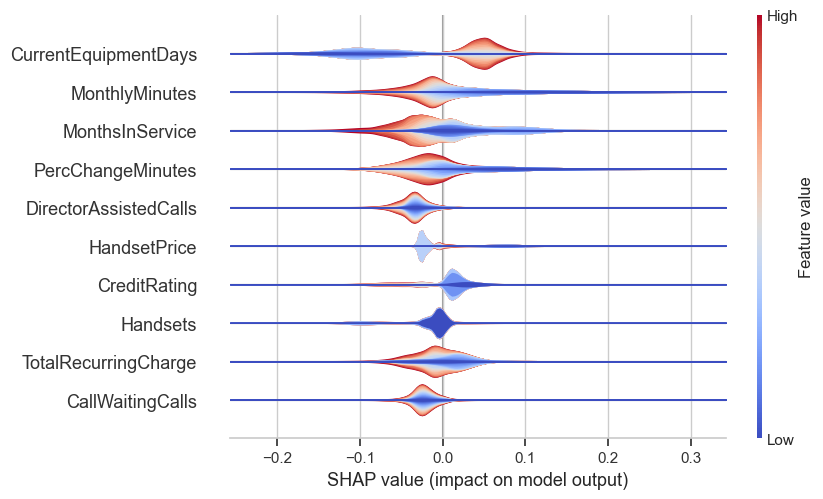

In [19]:
shap.plots.violin(shap_values=explainer_object.values[:,:], features=X_test, plot_type="layered_violin",max_display = 10)

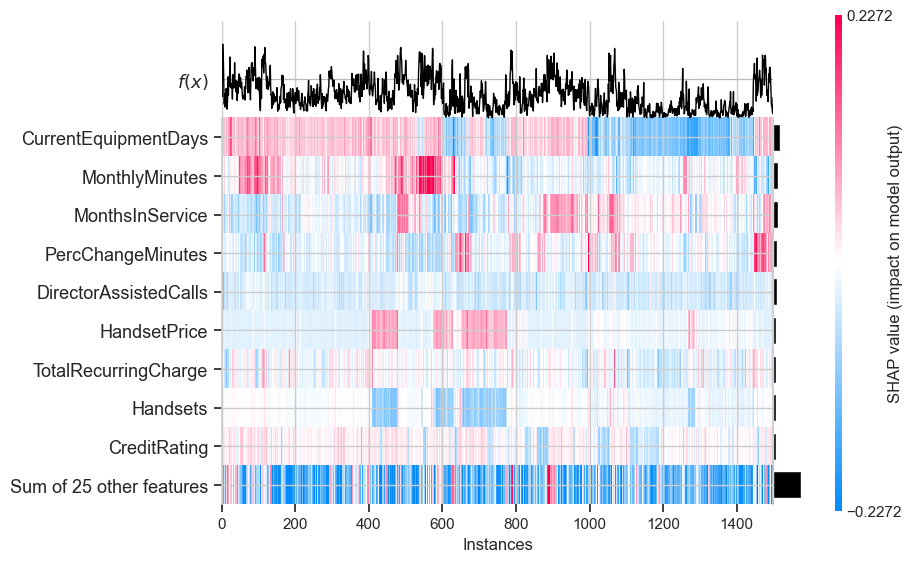

<Axes: xlabel='Instances'>

In [20]:
shap.plots.heatmap(shap_values=explainer_object[sample_idx,:], max_display=10)

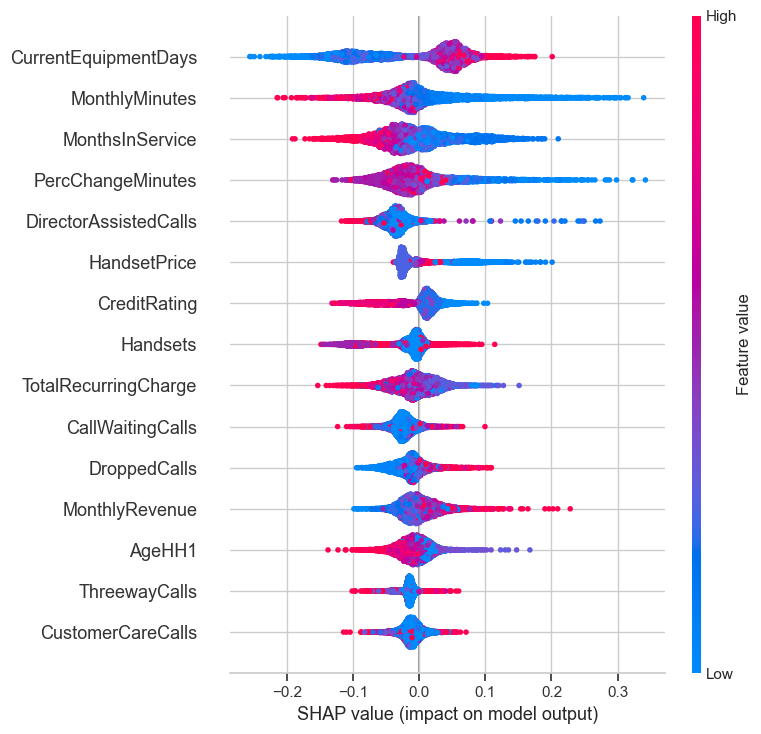

In [38]:
shap.summary_plot(shap_values=explainer_object.values[:,:],
                  features = X_test,
                  feature_names = feature_names,
                  max_display = 15,
                  plot_type = "dot")